In [1]:
import numpy as np
import scipy as sp
import scipy.stats

from tqdm import tqdm_notebook

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def _dot(a, b):
    return sum(np.inner(x.ravel(), y.ravel()) for x, y in zip(a, b))

class ExponentialFamilyDistribution(object):
    def __init__(self, *theta):
        self.theta = theta
        
    def A(self):
        return NotImplemented
    
    def T(self, x):
        return NotImplemented
    
    def h(self, x):
        return NotImplemented
    
    def pdf(self, x):
        return self.h(x) * np.exp(_dot(self.theta, self.T(x)) - self.A())
    
    def sample(self):
        raise NotImplemented
    
class GaussianDistribution(ExponentialFamilyDistribution):
    def __init__(self, *theta):
        super(GaussianDistribution, self).__init__(*theta)
        m, S = theta
        self.m = m
        self.S = S
        self.cov = np.linalg.pinv(S)
        self.mu = self.cov.dot(m)
        self.k = m.shape[0]
    
    def A(self):
        return 0.5 * (np.inner(self.m, self.cov.dot(self.m)) - np.log(np.linalg.det(self.S)))
    
    def grad_A(self):
        return (self.mu, -0.5 * (np.outer(self.mu, self.mu) + self.cov))
    
    def T(self, x):
        return (x, -0.5 * np.outer(x, x))
    
    def h(self, x):
        return (2 * np.pi) ** (-self.k / 2.)
        
    def sample(self):
        return np.random.multivariate_normal(mean=self.mu, cov=self.cov)

In [3]:
class DummyProjector(object):
    def __call__(self, *x):
        raise NotImplemented

class EyeProjector(DummyProjector):
    def __call__(self, x):
        return x
    
class CoordProjector(DummyProjector):
    def __init__(self, *coord_projectors):
        self.projectors = coord_projectors
    
    def __call__(self, *x):
        return tuple(proj(c) for c, proj in zip(x, self.projectors))

class BoxProjector(DummyProjector):
    def __init__(self, min_values, max_values):
        self.min = min_values
        self.max = max_values
        
    def __call__(self, x):
        return np.clip(x, a_min=self.min, a_max = self.max)
    
class EigenBoxProjector(BoxProjector):
    def __call__(self, x):
        eig, v = np.linalg.eig(x)
        eig = np.clip(eig, a_min=self.min, a_max = self.max) 
        return v.dot(np.diag(eig)).dot(v.T)

In [4]:
def step(old_theta, step_size, grad):
    return tuple(t - step_size * g for t, g in zip(old_theta, grad))

def projected_gradient(obj, f_class, projector, C, theta0, n_iters=1000):
    estimations = []
    thetas = [theta0]
    
    cumsum = 0
    theta = theta0
    for i in tqdm_notebook(range(1, n_iters + 1)):
        f = f_class(*theta)
        x = f.sample()
        
        cumsum += obj(x) / f.pdf(x)
        estimations.append(cumsum / i)
        
        mult = (obj(x) / f.pdf(x)) ** 2
        g = tuple(mult * (a - b) for a, b in zip(f.grad_A(), f.T(x)))        
        theta = projector(*step(theta, C / i ** 0.5, g))
        thetas.append(theta)
        
    return thetas, estimations

In [5]:
obj = lambda x: sp.stats.multivariate_normal.pdf(x, mean=[0, 0], cov=np.diag([1, 1]))

In [6]:
projector = CoordProjector(BoxProjector(-1, 1), EigenBoxProjector(1, 15))

In [7]:
thetas, estimations = projected_gradient(obj, GaussianDistribution, projector, 
                                         1e-2, (np.array([0, 0]), np.eye(2)), n_iters=10 ** 5)

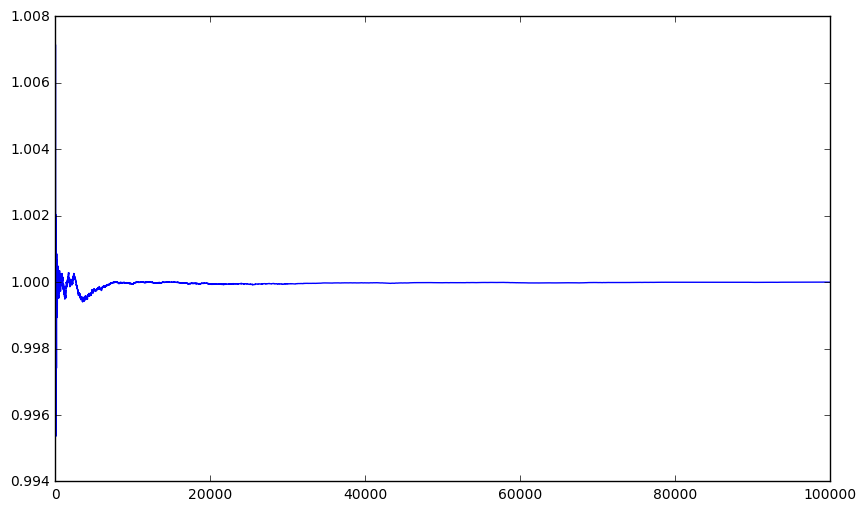

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(estimations))

In [9]:
f = lambda x: GaussianDistribution(x[:2], x[2:].reshape((2, 2))).A()
g =  lambda x: np.concatenate([x.ravel() for x in GaussianDistribution(x[:2], x[2:].reshape((2, 2))).grad_A()])

scipy.optimize.check_grad(f, g, np.array([np.random.random(), np.random.random(), 100, 0, 0, 100]))

5.0805743824247879e-08